In [1]:
import os
import multiprocessing
from scipy.io import loadmat
from scipy.stats import ranksums
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import h5py
from learned_tuning.learned_tuning import calculate_learned_tuning, calculate_place_field_fidelity_of_learned_tuning
import random


%matplotlib widget


data_dir = r'/home/kouroshmaboudi/Documents/Learned_tuning_Python/Datasets'
sessions = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

# included_session_IDX = [x for x in range(17) if x not in (12, 13)]
included_session_IDX = [8]

sessions = [sessions[i] for i in included_session_IDX]

for session_idx, session_name in enumerate(sessions):

    print(session_name)

    session_dataset_path = os.path.join(data_dir, session_name)
    session_number = included_session_IDX[session_idx]

    #------------------------------------------------------------------------------------------------------------------------------------
    # Load epochs information

    filename = f'{session_name}.fileInfo_for_python.mat'
    file_path = os.path.join(session_dataset_path, filename)

    mat_file = loadmat(file_path)
    session_info = mat_file["fileInfo"]

    epochs = session_info["behavior"][0][0][0][0]["time"]

    epoch_names = ['pre', 'maze', 'post']


    
    #---------------------------------------------------------------------------------------------------------------------------------------
    # Load spike data

    filename = f'{session_name}.spikes_for_python.mat'
    file_path = os.path.join(session_dataset_path, filename)

    mat_file = loadmat(file_path)
    spikes_pyr = mat_file["spikes_pyr"]

    #### Extracting all place fields from the imported .mat file
    spatial_tuning_smoothed = spikes_pyr["spatialTuning_smoothed"]

    num_units    = spatial_tuning_smoothed[0].shape[0]
    # num_units    = spatial_tuning_smoothed.shape[0] # for RatN only

    num_pos_bins = spatial_tuning_smoothed[0][0]['uni'][0][0].size

    # print(num_units, num_pos_bins)

    spikes = []; # spike data and place field info of each unit

    # attributes = list(spikes_pyr.dtype.names) % if we want to work on all variable in the imported .mat data structure
    running_directions = {'LR', 'RL', 'uni'}
    other_attributes   = {'spike_times', 'shank_id','cluster_id'}

    iter = 0
    for unit in range(num_units):
        
        # Create dictionaries for each unit and store the matrices
        
        unit_spikes = dict()

        unit_spikes['place_fields']  = {}
        unit_spikes['peak_pos_bins'] = {}
        unit_spikes['place_fields_remaze']  = {}
        unit_spikes['peak_pos_bins_remaze'] = {}
        
        for direction in running_directions:
            try:
                unit_spikes['place_fields'][direction] = spikes_pyr["spatialTuning_smoothed"][0][unit][direction][0][0].reshape(num_pos_bins) 
                unit_spikes['peak_pos_bins'][direction] = spikes_pyr['peakPosBin'][0][unit][direction][0][0][0][0]

                unit_spikes['place_fields_remaze'][direction] = spikes_pyr["spatialTuning_smoothed_re"][0][unit][direction][0][0].reshape(num_pos_bins) 
                unit_spikes['peak_pos_bins_remaze'][direction] = spikes_pyr['peakPosBin_re'][0][unit][direction][0][0][0][0]

            except ValueError:
                if iter == 0:
                    print("This session has only one running direction")
                iter += 1


        if session_number in [9, 10]: # for Rat V sessions
            unit_spikes['spike_times'] = spikes_pyr['time'][0][unit]
            unit_spikes['shank_id']    = spikes_pyr['id'][0][unit][0][1]
            unit_spikes['shank_id']    += 1
            unit_spikes['cluster_id']  = spikes_pyr['id'][0][unit][0][0]

        elif session_number in [6, 7]: # for RatN and RatS
            unit_spikes['spike_times'] = spikes_pyr['time'][unit][0] 
            unit_spikes['shank_id']    = spikes_pyr['id'][unit][0][0][0]
            unit_spikes['cluster_id']  = spikes_pyr['id'][unit][0][0][1]

        elif session_number == 8: # RatU  
            unit_spikes['spike_times'] = spikes_pyr['time'][0][unit]
            unit_spikes['shank_id']    = spikes_pyr['id'][0][unit][0][0] # shank indices already starts at zero
            unit_spikes['shank_id']    += 1
            unit_spikes['cluster_id']  = spikes_pyr['id'][0][unit][0][1]
        else: # Grosmark, Hiro, and all other sessions
            unit_spikes['spike_times'] = spikes_pyr['time'][0][unit]
            unit_spikes['shank_id']    = spikes_pyr['id'][0][unit][0][0] # need to go one down for the other datasets
            unit_spikes['cluster_id']  = spikes_pyr['id'][0][unit][0][1]


        spikes.append(unit_spikes) 



    #---------------------------------------------------------------------------------------------------------------------------------------------------
    # Spatial tunings
    spatial_tunings_maze = np.zeros((num_units, num_pos_bins))
    spatial_tunings_remaze = np.zeros((num_units, num_pos_bins))
    
    pre_post_unit_stability_curr_session = np.empty((num_units,))

    for unit in range(num_units):

        spatial_tunings_maze[unit] = spikes[unit]['place_fields']['uni']

        # reMAZE spatial tunings (all session except RatS with animal's positon on reMAZE recorded)
        if session_number in range(8, 11):  # RatU_Day2, RatV_Day1, RatV_day3
            spatial_tunings_remaze[unit] = spikes[unit]['place_fields_remaze']['uni']
            
    above_1Hz_PF_unit_index = np.nanmax(spatial_tunings_maze, axis=1) > 1



    # --------------------------------------------------------------------------------------------
    # Load cluster quality data (L-ratios)
    
    filename = f'{session_name}.clusterQuality.mat'
    file_path = os.path.join(session_dataset_path, filename)

    mat_file = loadmat(file_path)

    # Access data structure
    num_shanks = len(mat_file["clusterQuality"]["Lratio"][0])

    L_ratios = list()
    for shank in range(num_shanks):    
        curr_shank_L_ratios = dict()
        curr_shank_L_ratios["L_ratios"] = mat_file["clusterQuality"]["Lratio"][0][shank]
        curr_shank_L_ratios["cluster_ids"] = mat_file["clusterQuality"]["clus"][0][shank]
        
        L_ratios.append(curr_shank_L_ratios)
    



    #-------------------------------------------------------------------------------------------------------------------------------------------------------
    # Population Burst Events (PBEs)

    overwrite = False # in case we need to read the .mat file again, if there was a change

    filename = f'{session_name}.PBEs.pkl'
    file_path = os.path.join(session_dataset_path, filename)

    if os.path.exists(file_path) and overwrite == False:

        # PBEs = np.load(file_path, allow_pickle=True)
        PBEs = pd.read_pickle(file_path)
    else: # if it doesn't exist then read it from the .mat file

        filename = f'{session_name}.PBEInfo_replayScores.mat'
        file_path = os.path.join(session_dataset_path, filename)
        f = h5py.File(file_path, "r")
        PBEInfo = f['PBEInfo_replayScores']    
    

        # Store the population burst events in a pandas DataFrame
        num_PBEs = PBEInfo["fr_1msbin"].shape[0]
        attributes = list(PBEInfo.keys())

        PBEs = pd.DataFrame(columns=[attr for attr in attributes[1:] if attr not in ['posteriorProbMat', 'postMat_nonNorm']])

        # Loop over the PBEs and add each one as a row to the DataFrame
        num_dots = int(num_PBEs * (10/100))
        count = 0

        for pbe in range(num_PBEs): #  

            for attr in PBEs.columns:
                ref = PBEInfo[attr][pbe][0]
                obj = f[ref]

                if attr in ['epoch', 'brainState']: # convert the ascii code to string
                    arr = np.array(obj).flatten()
                    epoch = "".join(chr(code) for code in arr)
                    PBEs.at[pbe, attr] = epoch
                elif attr in ['fr_1msbin', 'fr_20msbin', 'posteriorProbMat', 'postMat_nonNorm']: # no need to flatten
                    arr = np.array(obj)
                    PBEs.at[pbe, attr] = arr
                else: 
                    arr = np.array(obj).flatten()
                    PBEs.at[pbe, attr] = arr

        if (pbe+1) % num_dots == 1:
            count += 1
            message = "Importing PBEs" + "." * count
            print(message, end="\r")

        print("All PBEs were imported") 
    
        filename = f'{session_name}.PBEs.pkl'
        file_path = os.path.join(session_dataset_path, filename)
        PBEs.to_pickle(file_path)

    num_PBEs = PBEs.shape[0]


RatU_Day2NSD_2021-07-24_08-16-38


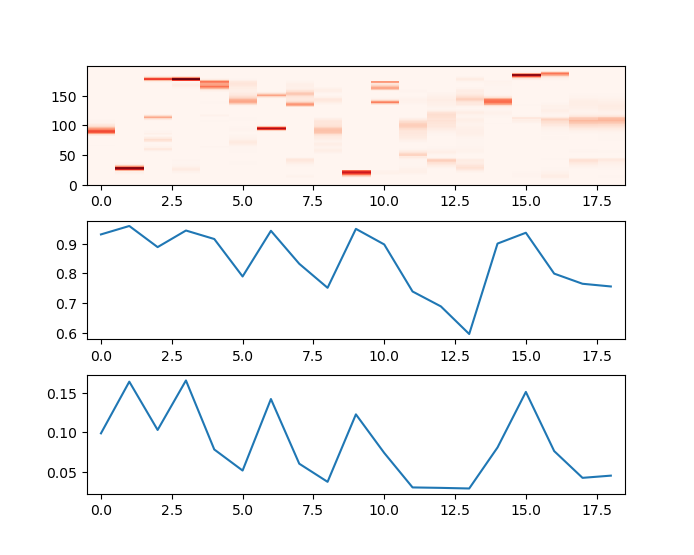

In [33]:
def gini(x):
    # Mean absolute difference 
    mad = np.abs(np.subtract.outer(x,x)).mean()
    # Relative mean absoulte difference 
    rmad = mad/np.mean(x)
    # Gini coefficient 
    g = 0.5*rmad
    return g


num_pos_bins_interp = 200
interp_pos_bins = np.linspace(0, num_pos_bins, num_pos_bins_interp)

# def get_interpolated_data(interpolation_points, original_points, original_data):
#     interpolated_data = np.interp(interpolation_points, original_points, original_data)
#     return interpolated_data

posterior_prob = PBEs.at[0, 'posteriorProbMat']
# posterior_prob_interp = np.apply_along_axis(get_interpolated_data, axis = 0, arr = posterior_prob, interpolation_points = interp_pos_bins, original_points = np.arange(1, num_pos_bins+1))


num_time_bins = posterior_prob.shape[0]
posterior_prob_interp = np.full((num_pos_bins_interp, num_time_bins), np.nan)
gini_coeff = np.full((num_time_bins,), np.nan)
peak_posterior = np.full((num_time_bins,), np.nan)
for time_bin in range(num_time_bins):
    curr_posterior_prob_interp = np.interp(interp_pos_bins, np.arange(0, num_pos_bins), posterior_prob[time_bin, :])
    posterior_prob_interp[:, time_bin] = curr_posterior_prob_interp/np.sum(curr_posterior_prob_interp)
    
    gini_coeff[time_bin] = gini(posterior_prob_interp[:, time_bin])
    peak_posterior[time_bin] = max(posterior_prob_interp[:, time_bin])



plotheight = 400
plotwidth = 500
font_size = 5

fig = plt.figure()
fig.set_size_inches([plotwidth/72, plotheight/72])
gs = GridSpec(nrows=3, ncols=1, figure=fig, hspace=0.3, wspace=0.5)

ax0 = fig.add_subplot(gs[0])
ax0.imshow(posterior_prob_interp, origin='lower', interpolation='none', cmap = 'Reds')
ax0.set_aspect('auto')

ax1 = fig.add_subplot(gs[1], sharex = ax0)
ax1.plot(gini_coeff)

ax2 = fig.add_subplot(gs[2], sharex = ax0)
ax2.plot(peak_posterior)



### How many ripples are needed to calculate the learned tunings
The code calculates the learned tunings based on different subsets of PBEs to investigate the effect of PBE subset size on the learned tunings' fidelity to corresponding place fields


In [13]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) # we have division by zeros somewhere in the code that we need to fix, but for now we suppress it because it's not causing a major issue ...

num_units_above_1Hz = len(np.where(above_1Hz_PF_unit_index)[0])

storage_dir = r'/home/kouroshmaboudi/Documents/Learned_tuning_Python/'
filename = f'{session_name}.learned_tunings_vs_ripple_subset_size_medians_MAZE.npy'
file_path = os.path.join(storage_dir, filename)

overwrite = False

if os.path.exists(file_path) and overwrite == False:
    median_LT_PF_corr_diff_sizes = np.load(file_path, allow_pickle= True).item() # use this to read the files
    
else:
    PBEs_maze = PBEs.loc[PBEs['epoch'] == 'run'].reset_index(drop=True)
    num_pbes_total = PBEs_maze.shape[0]

    num_iterations = 10  # Number of iterations
    step_size = 2
    maximum_subset_size = num_pbes_total 
    random.seed(100)  # Set random seed for reproducibility
    time_bin_duration=0.02
    num_PF_shuffles = 10000 # number of place field unit ID shuffles to calculate the null distributions

    def process_subset(subset_size): 
        # print(f"subset_size =  {subset_size}")

        subset_indices = random.sample(range(num_pbes_total), subset_size + 1)  # Randomly sample subset indices
        PBE_subset = PBEs_maze.loc[subset_indices].reset_index(drop=True)  # Get the randomized subset of PBEs

        # Execute base process on the PBE subset:
        # caluclate the learned tunings
        learned_tunings = calculate_learned_tuning(PBE_subset, spikes, L_ratios, time_bin_duration)
        
        # calculate PF fidelities of the learned tunings
        learned_tuning_place_field_corr, _, median_LT_PF_corr = calculate_place_field_fidelity_of_learned_tuning(learned_tunings[above_1Hz_PF_unit_index], spatial_tunings_maze[above_1Hz_PF_unit_index], num_PF_shuffles)

        return subset_size, learned_tuning_place_field_corr, median_LT_PF_corr


    learned_tunings_PBE_subsets_diff_sizes = {}  # Use dictionary to store results by subset size
    median_LT_PF_corr_diff_sizes = {}

    # Creat a  pool of processes
    num_processes = 10
    pool = multiprocessing.Pool(processes = num_processes)

    # Create a list of subset sizes to process in parallel
    subset_sizes = list(range(step_size, maximum_subset_size, step_size)) 

    for subset_size in subset_sizes:
        learned_tunings_PBE_subsets_diff_sizes[subset_size] = np.full((num_units_above_1Hz, num_iterations), np.nan)
        median_LT_PF_corr_diff_sizes[subset_size] = []


    # Loop for each iteration
    for i in range(num_iterations):
        print(f"Iteration {i+1}")

        # Use the pool to process the subset sizes in parallel
        results = pool.map(process_subset, subset_sizes)

        # Store results in dictionary by subset size
        for subset_size, learned_tuning_place_field_corr, median_LT_PF_corr in results:
            learned_tunings_PBE_subsets_diff_sizes[subset_size][:, i] = learned_tuning_place_field_corr
            median_LT_PF_corr_diff_sizes[subset_size].append(median_LT_PF_corr)


    # store the results
    np.save(file_path, median_LT_PF_corr_diff_sizes)



#### Plot the median place field fidelities as a function ripple subset size

In [14]:
# Create a list with separate items containing PF fidleities from all iterations corresponding to each ripple subset size

median_LT_PF_corr = {}
median_LT_PF_corr_p_value = {}
subset_sizes = list(median_LT_PF_corr_diff_sizes.keys())
num_iterations = len(median_LT_PF_corr_diff_sizes[subset_sizes[0]])


for subset_size in subset_sizes:
    median_LT_PF_corr[subset_size] = []
    median_LT_PF_corr_p_value[subset_size] = []
    for iter in range(num_iterations):
        median_LT_PF_corr[subset_size].append(median_LT_PF_corr_diff_sizes[subset_size][iter]["data"])
        median_LT_PF_corr_p_value[subset_size].append(median_LT_PF_corr_diff_sizes[subset_size][iter]["p_value"])


# Concatenate everythng to plot
tot_num_medians = num_iterations * len(subset_sizes)
ripple_set_size_all = np.full(tot_num_medians, np.nan)
median_fidelities_all = np.full(tot_num_medians, np.nan)
median_fidelity_pvalues_all = np.full(tot_num_medians, np.nan)

t = 0
for key, values in median_LT_PF_corr.items():
    ripple_set_size_all[t:(t+len(values))] = [key]*len(values)
    median_fidelities_all[t:(t+len(values))] = values
    t = t + len(values)

t=0
for _, values in median_LT_PF_corr_p_value.items():
    median_fidelity_pvalues_all[t:(t+len(values))] = values
    t = t + len(values)


xvar = np.array(ripple_set_size_all)
yvar = np.array(median_fidelities_all)
z = np.array(median_fidelity_pvalues_all)

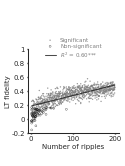

In [15]:
from scipy.stats import linregress
from matplotlib.ticker import FuncFormatter

# ---------------------------------------------------------------------------------------------------------------------------------------------------------------
# Define functions

def get_pval_statement(pvalue):
    
    if pvalue <= 0.0001:
        pvalue_statement = '***'
    elif pvalue < 0.001:
        pvalue_statement = '**'
    elif pvalue < 0.01:
        pvalue_statement = '*'
    else:
        pvalue_statement = f'P={pvalue:.2f}'
    
    return pvalue_statement

def format_ticks(x, _):
    if x == int(x):
        return str(int(x))
    else:
        return str(x)

#-----------------------------------------------------------------------------------------------------------------------------------------------------------------
# Set up figure colors and style


sns.set_style('whitegrid') 
sns.set_context('paper')

custom_params = {
    "axes.spines.top": False,
    "axes.spines.right": False
    }

sns.set_theme(style="ticks", rc=custom_params)

plt.rcParams.update({
    'font.size':5,
    'axes.linewidth':0.75,
    'pdf.fonttype':42,
    'ps.fonttype':42,
    'axes.labelsize':5,
    'axes.titlesize':6,
    'xtick.labelsize':5,
    'ytick.labelsize':5,
    'legend.fontsize':5,
    'legend.title_fontsize':6,
    'legend.frameon': False,
    'legend.markerscale':2,
    'xtick.major.size':2,
    'ytick.major.size':2
})

#-------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Generate the figure

plotheight = 120
plotwidth = 90
font_size = 5

fig = plt.figure()
fig.set_size_inches([plotwidth/72, plotheight/72])
gs = GridSpec(nrows=1, ncols=1, figure=fig, hspace=0.3, wspace=0.5)

ax = fig.add_subplot(gs[0])


# Scatterplot

# significant median
sns.scatterplot(
    x=xvar[z < 0.01],
    y=yvar[z < 0.01],
    color = 'gray',
    marker='o',
    edgecolor = 'none',
    linewidth=0, 
    s=1, 
    alpha=0.8, 
    ax=ax, 
    label = 'Significant'#'$P<10^{-4}$' 
    )



# Insignificant medians
# z_intervals = [[0, 0.001],
#                [0.001, 0.01],
#                [0.01, 1.01]]

z_intervals = [[0.01, 1.01]]
                
for z_interval_index, z_interval in enumerate(z_intervals):
    included_indexes = (z > z_interval[0]) & (z< z_interval[1])
    sns.scatterplot(
        x=xvar[included_indexes],
        y=yvar[included_indexes],
        color = 'none',
        marker='o',
        edgecolor = 'black',
        linewidth=0.25, 
        s=1+(z_interval_index+1), 
        alpha=0.8, 
        ax=ax, 
        label = 'Non-significant', #f'{z_interval[0]} < P < {z_interval[1]}' if z_interval_index < 2 else f'P > {z_interval[0]}',
        legend="brief"
        )




# Add the regression line
reg_valid_idx = ~np.isnan(xvar) & ~np.isnan(yvar)

slope, intercept, r_value, p_value, std_err = linregress(
    xvar[reg_valid_idx],
    yvar[reg_valid_idx]
    )
sns.regplot(x=xvar, y=yvar, ci=95, color='black', scatter=False,
            label=f'$R^{2}$ = {r_value**2:.2f}{get_pval_statement(p_value)}',
            line_kws={"linewidth":0.75, "alpha":0.7},
            ax=ax)



ax.set_ylim([-.2, 1])

# ax.set_xticks(np.linspace(0,200, 6))
ax.set_yticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

ax.set_xlabel("Number of ripples", fontsize=font_size, labelpad=1)
ax.set_ylabel("LT fidelity", fontsize=font_size, labelpad=0)

ax.tick_params(axis='both', which='major', length=1, pad=1, width=1)

ax.legend(fontsize=4, loc="upper center", bbox_to_anchor=(0.5, 1.2), markerscale = 1, labelspacing= 0.2, labelcolor = 'gray')


# Format the tick labels using the custom formatter
ax.xaxis.set_major_formatter(FuncFormatter(format_ticks))
ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))

# Adjust the plot layout
plt.subplots_adjust(left=0.22, right= 0.95, bottom=0.2, top=0.70)


plt.show()


filename = f'{session_name}.PF_fidelity_vs_ripple_subset_size_MAZE.pdf' # _percentile
storage_dir = r'/home/kouroshmaboudi/Documents/Learned_tuning_Python'
file_path = os.path.join(storage_dir, filename)

plt.savefig(file_path, dpi=300)

### How the number of units used for calculation of the learned tuning impact the quality of the learned tunings?

In [2]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) # we have division by zeros somewhere in the code that we need to fix, but for now we suppress it because it's not causing an issue ...

units_above_1Hz = np.where(above_1Hz_PF_unit_index)[0]
num_units_above_1Hz = len(units_above_1Hz)


storage_dir = r'/home/kouroshmaboudi/Documents/Learned_tuning_Python'
filename = f'{session_name}.learned_tunings_vs_number_of_units_for_calculation_medians_MAZE.npy'
file_path = os.path.join(storage_dir, filename)

overwrite = True

if os.path.exists(file_path) and overwrite == False:
    median_LT_PF_corr_unit_subsets = np.load(file_path, allow_pickle= True).item() # use this to read the files
    
else:

    PBEs_maze = PBEs.loc[PBEs['epoch'] == 'run'].reset_index(drop=True)
    num_pbes_total = PBEs_maze.shape[0]

    num_iterations = 10  # Number of iterations
    step_size = 2
    maximum_subset_size = num_units
    random.seed(100)  # Set random seed for reproducibility
    time_bin_duration=0.02
    num_PF_shuffles=10000 # number of place field unit ID shuffles to calculate the null distributions


    def process_subset(subset_size):
        
        unit_subset = np.array(random.sample(range(num_units), subset_size))
        # Define a list of PBE dictionaries
        PBEs_unit_subset = PBE_subset.copy()
        for pbe in range(len(PBE_subset)):   
            PBEs_unit_subset.at[pbe, 'fr_20msbin'] = PBE_subset.at[pbe, 'fr_20msbin'][:, unit_subset]

        spikes_unit_subset = [spikes[i] for i in unit_subset]

        learned_tunings = np.zeros((num_units, num_pos_bins))
        learned_tunings[unit_subset] = calculate_learned_tuning(PBEs_unit_subset, spikes_unit_subset, L_ratios, time_bin_duration)
        
        units_in_unit_subset_with_above_1Hz_PF = unit_subset[np.isin(unit_subset, units_above_1Hz)]

        # calculate PF fidelities of the learned tunings
        learned_tuning_place_field_corr, _, median_LT_PF_corr = calculate_place_field_fidelity_of_learned_tuning(
                                        learned_tunings[units_in_unit_subset_with_above_1Hz_PF],
                                        spatial_tunings_maze[units_in_unit_subset_with_above_1Hz_PF, :],
                                        num_PF_shuffles)

        return subset_size, learned_tuning_place_field_corr, median_LT_PF_corr

    
    subset_indices = random.sample(range(num_pbes_total), 200)  # Randomly sample subset indices
    PBE_subset = PBEs_maze.loc[subset_indices].reset_index(drop=True)  # Get the randomized subset of PBEs


    # learned_tunings_unit_subsets = {}  # Use dictionary to store results by subset size
    median_LT_PF_corr_unit_subsets = {}


    # Creat a  pool of processes
    num_processes = 10
    pool = multiprocessing.Pool(processes = num_processes)

    # Create a list of subset sizes to process in parallel
    subset_sizes = list(range(step_size, maximum_subset_size, step_size)) 
    for subset_size in subset_sizes:
        # learned_tunings_unit_subsets[subset_size] = np.full((subset_size, num_iterations), np.nan)
        median_LT_PF_corr_unit_subsets[subset_size] = []


    # Loop for each iteration
    for i in range(num_iterations):
        print(f"Iteration {i+1}")

        # Use the pool to process the subset sizes in parallel
        results = pool.map(process_subset, subset_sizes)

        # Store results in dictionary by subset size
        for subset_size, learned_tuning_place_field_corr, median_LT_PF_corr in results:
            # learned_tunings_unit_subsets[subset_size][:, i] = learned_tuning_place_field_corr
            median_LT_PF_corr_unit_subsets[subset_size].append(median_LT_PF_corr)

    # Store the results
    np.save(file_path, median_LT_PF_corr_unit_subsets)


Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10


In [3]:
# Create a list with separate items containing PF fidleities from all iterations corresponding to each number of units

median_LT_PF_corr = {}
median_LT_PF_corr_p_value = {}
subset_sizes = list(median_LT_PF_corr_unit_subsets.keys())
num_iterations = len(median_LT_PF_corr_unit_subsets[subset_sizes[0]])


for subset_size in subset_sizes:
    median_LT_PF_corr[subset_size] = []
    median_LT_PF_corr_p_value[subset_size] = []
    for iter in range(num_iterations):
        median_LT_PF_corr[subset_size].append(median_LT_PF_corr_unit_subsets[subset_size][iter]["data"])
        median_LT_PF_corr_p_value[subset_size].append(median_LT_PF_corr_unit_subsets[subset_size][iter]["p_value"])


# Concatenate everythng to plot
tot_num_medians = num_iterations * len(subset_sizes)
unit_subset_size_all = np.full(tot_num_medians, np.nan)
median_fidelities_all = np.full(tot_num_medians, np.nan)
median_fidelity_pvalues_all = np.full(tot_num_medians, np.nan)

t = 0
for key, values in median_LT_PF_corr.items():
    unit_subset_size_all[t:(t+len(values))] = [key]*len(values)
    median_fidelities_all[t:(t+len(values))] = values
    t = t + len(values)

t=0
for _, values in median_LT_PF_corr_p_value.items():
    median_fidelity_pvalues_all[t:(t+len(values))] = values
    t = t + len(values)


xvar = np.array(unit_subset_size_all)
yvar = np.array(median_fidelities_all)
z = np.array(median_fidelity_pvalues_all)


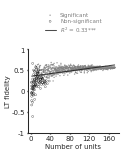

In [4]:
from scipy.stats import linregress
from matplotlib.ticker import FuncFormatter

# ---------------------------------------------------------------------------------------------------------------------------------------------------------------
# Define functions

def get_pval_statement(pvalue):
    
    if pvalue <= 0.0001:
        pvalue_statement = '***'
    elif pvalue < 0.001:
        pvalue_statement = '**'
    elif pvalue < 0.01:
        pvalue_statement = '*'
    else:
        pvalue_statement = f'P={pvalue:.2f}'
    
    return pvalue_statement

def format_ticks(x, _):
    if x == int(x):
        return str(int(x))
    else:
        return str(x)

#-----------------------------------------------------------------------------------------------------------------------------------------------------------------
# Set up figure colors and style


sns.set_style('whitegrid') 
sns.set_context('paper')

custom_params = {
    "axes.spines.top": False,
    "axes.spines.right": False
    }

sns.set_theme(style="ticks", rc=custom_params)

plt.rcParams.update({
    'font.size':5,
    'axes.linewidth':0.75,
    'pdf.fonttype':42,
    'ps.fonttype':42,
    'axes.labelsize':5,
    'axes.titlesize':6,
    'xtick.labelsize':5,
    'ytick.labelsize':5,
    'legend.fontsize':5,
    'legend.title_fontsize':6,
    'legend.frameon': False,
    'legend.markerscale':2,
    'xtick.major.size':2,
    'ytick.major.size':2
})

#-------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Generate the figure

plotheight = 120
plotwidth = 90
font_size = 5

fig = plt.figure()
fig.set_size_inches([plotwidth/72, plotheight/72])
gs = GridSpec(nrows=1, ncols=1, figure=fig, hspace=0.3, wspace=0.5)

ax = fig.add_subplot(gs[0])


# Scatterplot

# significant median
sns.scatterplot(
    x=xvar[z < 0.01],
    y=yvar[z < 0.01],
    color = 'gray',
    marker='o',
    edgecolor = 'none',
    linewidth=0, 
    s=1, 
    alpha=0.8, 
    ax=ax, 
    label = 'Significant'#'$P<10^{-4}$' 
    )



# Insignificant medians
# z_intervals = [[0, 0.001],
#                [0.001, 0.01],
#                [0.01, 1.01]]

z_intervals = [[0.01, 1.01]]
                
for z_interval_index, z_interval in enumerate(z_intervals):
    included_indexes = (z > z_interval[0]) & (z< z_interval[1])
    sns.scatterplot(
        x=xvar[included_indexes],
        y=yvar[included_indexes],
        color = 'none',
        marker='o',
        edgecolor = 'black',
        linewidth=0.25, 
        s=1+(z_interval_index+1), 
        alpha=0.8, 
        ax=ax, 
        label = 'Non-significant', #f'{z_interval[0]} < P < {z_interval[1]}' if z_interval_index < 2 else f'P > {z_interval[0]}',
        legend="brief"
        )

    

# Add the regression line
reg_valid_idx = ~np.isnan(xvar) & ~np.isnan(yvar)

slope, intercept, r_value, p_value, std_err = linregress(
    xvar[reg_valid_idx],
    yvar[reg_valid_idx]
    )
sns.regplot(x=xvar, y=yvar, ci=95, color='black', scatter=False,
            label=f'$R^{2}$ = {r_value**2:.2f}{get_pval_statement(p_value)}',
            line_kws={"linewidth":0.75, "alpha":0.7},
            ax=ax)

ax.set_ylim([-1, 1])

ax.set_xticks(np.arange(0, np.ceil(num_units/10)*10, 40))
# ax.set_yticks(np.linspace(0, 0.4, 3))

ax.set_xlabel("Number of units", fontsize=font_size, labelpad=1)
ax.set_ylabel("LT fidelity", fontsize=font_size, labelpad=0)

ax.tick_params(axis='both', which='major', length=1, pad=1, width=1)

ax.legend(fontsize=4, loc="upper center", bbox_to_anchor=(0.5, 1.5), markerscale = 1, labelspacing= 0.2, labelcolor = 'gray')

# Format the tick labels using the custom formatter
ax.xaxis.set_major_formatter(FuncFormatter(format_ticks))
ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))

# Adjust the plot layout
plt.subplots_adjust(left=0.22, right= 0.95, bottom=0.2, top=0.70)



plt.show()

filename = f'{session_name}.PF_fidelity_vs_number_of_units_MAZE.pdf' # _percentile
storage_dir = r'/home/kouroshmaboudi/Documents/Learned_tuning_Python'
file_path = os.path.join(storage_dir, filename)

plt.savefig(file_path, dpi=300)